In [8]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import scale
import scipy.ndimage

In [9]:
'''Data was the same data that was used for the notMNIST lesson'''

labels = np.load("../data/notMNIST/train_labels.npy")
train_images = np.load("../data/notMNIST/train_images.npy")
test_images = np.load("../data/notMNIST/test_images.npy")
label_names = np.array(['A','B','C','D','E','F','G','H','I','J'])

In [10]:
def get_image_and_label(image_number):
    plt.matshow(train_images[image_number], cmap=plt.cm.gray)
    print(label_names[labels[image_number]])

def show_image(image):
        plt.matshow(image, cmap=plt.cm.gray)

In [11]:
'''
This code shows what the effect of these scaling functions is. Tensorflow actually has image scaling built in as well. 
print("Origional image")
show_image(train_images[0])
print("Downscaled by 1/2")
show_image(scipy.ndimage.zoom(train_images[0],.5))
print("Upscaled back to origional")
show_image(scipy.ndimage.zoom(scipy.ndimage.zoom(train_images[0],.5),2))
'''

'\nThis code shows what the effect of these scaling functions is. Tensorflow actually has image scaling built in as well. \nprint("Origional image")\nshow_image(train_images[0])\nprint("Downscaled by 1/2")\nshow_image(scipy.ndimage.zoom(train_images[0],.5))\nprint("Upscaled back to origional")\nshow_image(scipy.ndimage.zoom(scipy.ndimage.zoom(train_images[0],.5),2))\n'

In [12]:
'''This code creates downscaled datasets that can be used for training. 

'''
downscaled_train = np.array([scipy.ndimage.zoom(i,.5,mode='nearest') for i in train_images])
downscaled_test = np.array([scipy.ndimage.zoom(i,.5,mode='nearest') for i in test_images])
print(downscaled_train.shape)
print(train_images.shape)

(100, 14, 14)
(100, 28, 28)


In [13]:
'''
Model 3

Uses convolution
'''
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride_input = [1, 2, 2, 1]):
  return tf.nn.conv2d(x, W, strides = stride_input, padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

small_train = tf.placeholder('float32', shape = [None, 14, 14])
large_train = tf.placeholder('float32', shape = [None, 28, 28])

small_train_flattened = tf.reshape(small_train,[-1,14*14])
large_train_flattened = tf.reshape(large_train,[-1,28*28])

reshaped_to_image_format = tf.reshape(small_train,[-1,14,14,1])

n_1 = 32
n_2 = 16
#n_3 = 

w_conv1 = weight_variable([2,2,1,n_1]) #7
b_conv1 = bias_variable([n_1])
h_conv1 = tf.nn.relu(conv2d(reshaped_to_image_format, w_conv1, stride_input = [1, 1, 1, 1]) + b_conv1)


w_conv2 = weight_variable([1,1,n_1,n_2]) #7
b_conv2 = bias_variable([n_2])
h_conv2 = tf.nn.relu(conv2d(h_conv1, w_conv2, stride_input = [1, 1, 1, 1]) + b_conv2)


w_conv_inv1 = weight_variable([4,4,1,n_2])
#b_conv_inv1 =
h_conv_inv1 = tf.nn.conv2d_transpose(h_conv2, w_conv_inv1, [100,28,28,1], [1,2,2,1])

final = tf.nn.tanh(h_conv_inv1)

prediction = tf.reshape(final,[-1,28*28])

#h_pool1 = max_pool_2x2(h_conv1)

#Decision layer
#w = tf.Variable(tf.truncated_normal([14*14, 28*28]))
#b = tf.Variable(tf.truncated_normal([1,28*28]))
#prediction = tf.matmul(small_train_flattened,w)+b


#Loss / prediction / optimization etc. 
MSE = tf.reduce_mean(tf.square(prediction - large_train_flattened))
pred = tf.reshape(prediction,[-1,28,28])
optimizer = tf.train.AdamOptimizer().minimize(MSE)

init = tf.initialize_all_variables()

In [14]:
sess = tf.Session()
sess.run(init)

In [15]:
MAXSTEPS = 3001
for step in range(MAXSTEPS):
    (_,mse) = sess.run([optimizer,MSE],feed_dict = {small_train: downscaled_train, large_train: train_images})
    if (step % 1000) == 0:
        test_mse = sess.run(MSE, feed_dict = {small_train: downscaled_test, large_train: test_images})
        print('step = %-5d MSE = %-10f Test MSE = %-10f' % (step,mse,test_mse))
print("Done!")

step = 0     MSE = 0.211666   Test MSE = 0.209942  
step = 1000  MSE = 0.019980   Test MSE = 0.021208  
step = 2000  MSE = 0.016998   Test MSE = 0.018676  
step = 3000  MSE = 0.015972   Test MSE = 0.017660  
Done!


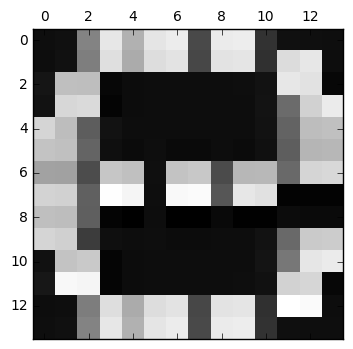

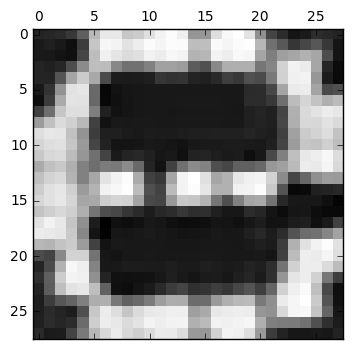

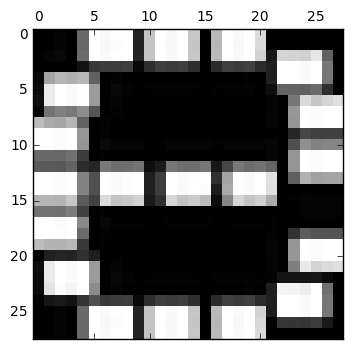

In [16]:
test_pred = sess.run(pred, feed_dict = {small_train: downscaled_test})
train_pred = sess.run(pred, feed_dict = {small_train: downscaled_train})
to_show = 7
show_image(downscaled_test[to_show])
show_image(test_pred[to_show])
show_image(test_images[to_show])